In [77]:
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from dust_extinction.parameter_averages import CCM89, F99
from synphot import units, config, SourceSpectrum,SpectralElement,Observation,ExtinctionModel1D
from synphot.models import BlackBodyNorm1D
from synphot.spectrum import BaseUnitlessSpectrum
from synphot.reddening import ExtinctionCurve
from astroquery.simbad import Simbad
from astroquery.mast import Observations
import astropy.visualization
import requests
import os
import glob
import warnings



<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_140479/1560572527.py:17: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda^{-1}$ ($\mu$m$^{-1}$)')
/tmp/ipykernel_140479/1560572527.py:18: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel('A($\lambda$) / A(V)')


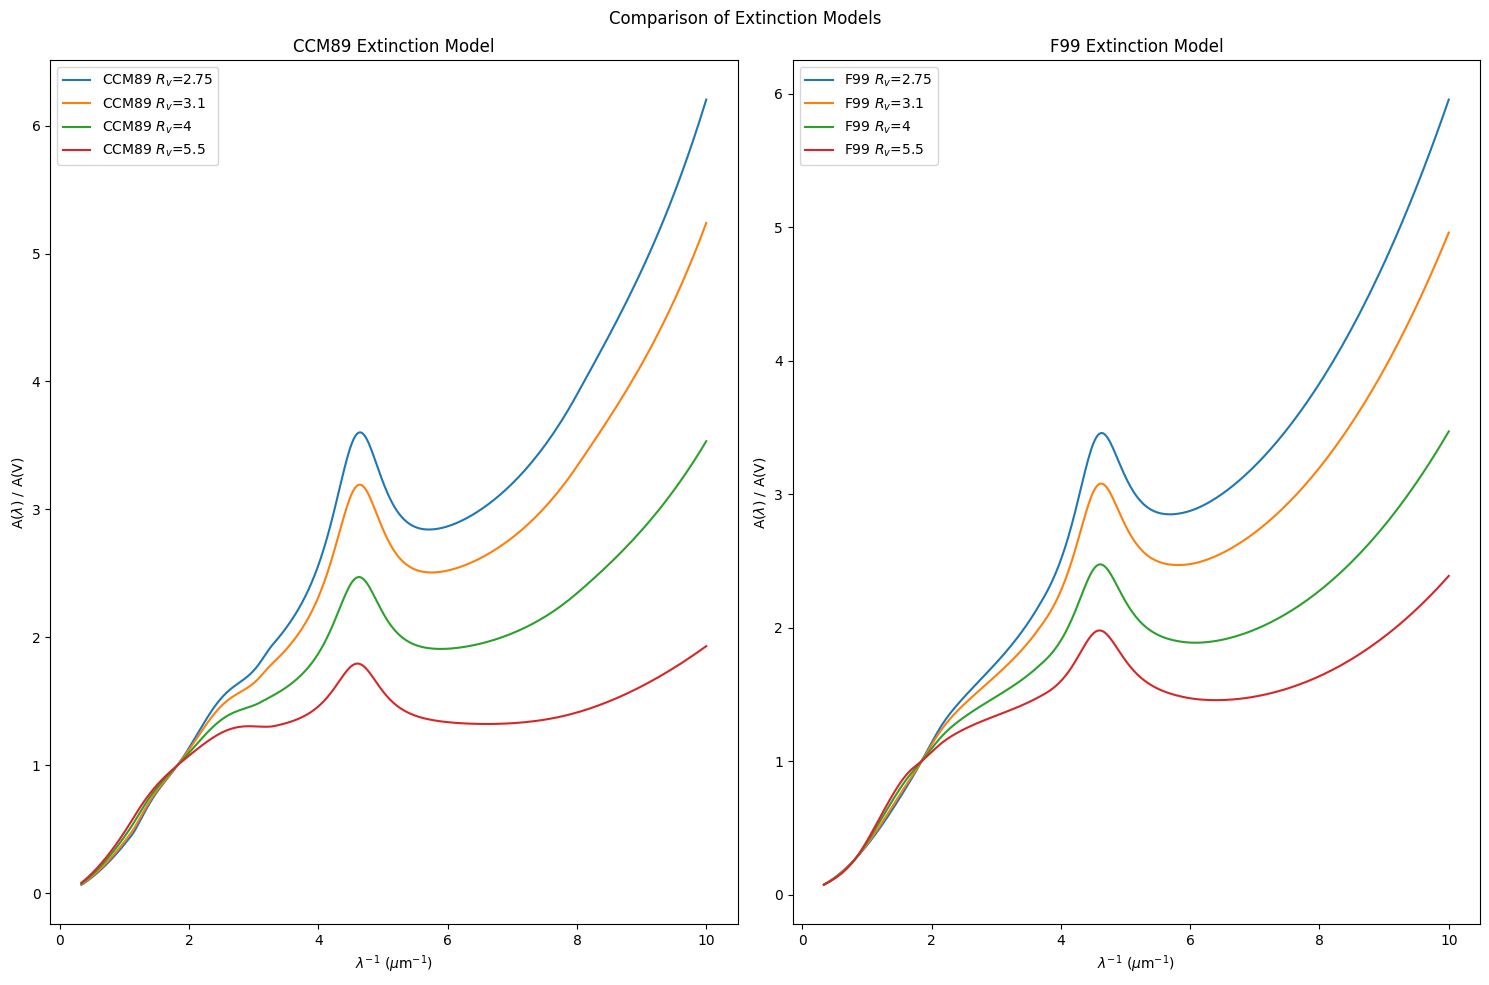

In [31]:
# Create wavelengths array.
wav = np.arange(0.1, 3.0, 0.001) * u.micron

# Initialize the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

# Define the models
models = [CCM89, F99]
titles = ['CCM89 Extinction Model', 'F99 Extinction Model']

for ax, model, title in zip(axs, models, titles):
    for R in (2.75, 3.1, 4, 5.5):
        # Initialize the extinction model
        ext = model(Rv=R)
        ax.plot(1 / wav, ext(wav), label=model.name + ' $R_v$=' + str(R))
    
    ax.set_xlabel('$\lambda^{-1}$ ($\mu$m$^{-1}$)')
    ax.set_ylabel('A($\lambda$) / A(V)')
    ax.legend(loc='best')
    ax.set_title(title)

plt.suptitle('Comparison of Extinction Models')
plt.tight_layout()
plt.show()


In [80]:
# Define the download directory
download_dir = pathlib.Path('~/.astropy/cache/astroquery/Mast').expanduser()
download_dir.mkdir(exist_ok=True)

# Query for the object
obsTable = Observations.query_object("HD 147933", radius="1 arcsec")
obsTable_spec = obsTable[obsTable['dataproduct_type'] == 'spectrum']
# Further filter to include only UV readings
obsTable_uv = obsTable_spec[obsTable_spec['wavelength_region'] == 'UV']

# Extract URLs from the dataURL column
urls = obsTable_uv['dataURL']

In [60]:
# List to store file names
Names = []

# Function to download .fits files
def download_file(url, directory):
    if url.endswith('.fits'):
        try:
            response = requests.get(url)
            response.raise_for_status()  # Check for HTTP request errors
            
            # Extract the file name from the URL
            filename = pathlib.Path(url).name
            file_path = directory / filename
            
            # Save the file
            with open(file_path, 'wb') as file:
                file.write(response.content)
            
            print(f"Downloaded {url}")
            
            # Append the filename to the list
            Names.append(filename)
        except requests.RequestException as e:
            print(f"Error {url}: {e}")


# Download only .fits files
for url in urls:
    try:
        download_file(url, download_dir)
    except Exception as e:
        print(f"File could not be downloaded: {e}")
        continue

Downloaded http://archive.stsci.edu/pub/vospectra/iue2/lwr05639mxlo_vo.fits
Downloaded http://archive.stsci.edu/pub/vospectra/iue2/lwr05640mxlo_vo.fits
Downloaded http://archive.stsci.edu/pub/vospectra/iue2/lwr10501mxlo_vo.fits
Downloaded http://archive.stsci.edu/pub/vospectra/iue2/lwr10534mxlo_vo.fits
Downloaded http://archive.stsci.edu/pub/vospectra/iue2/swp06587mxlo_vo.fits
Downloaded http://archive.stsci.edu/pub/vospectra/iue2/swp06588mxlo_vo.fits
Downloaded http://archive.stsci.edu/pub/vospectra/iue2/swp06589mxlo_vo.fits
Downloaded http://archive.stsci.edu/pub/vospectra/iue2/swp13864mxlo_vo.fits
Downloaded http://archive.stsci.edu/pub/vospectra/iue2/swp13904mxlo_vo.fits
Error downloading mast:HST/product/hasp/hst_13365_stis_hd147933_e140h-e230h_oc9a_cspec.fits: No connection adapters were found for 'mast:HST/product/hasp/hst_13365_stis_hd147933_e140h-e230h_oc9a_cspec.fits'
Error downloading mast:HST/product/hasp/hst_15335_stis_-rho-oph-a_e230m_odlz_cspec.fits: No connection adapte

In [78]:
# Read the first FITS file as a table
if Names:
    first_file_name = Names[0]
    first_file_path = download_dir / first_file_name
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        try:
            # Read the FITS file into an Astropy Table
            table = Table.read(first_file_path, format='fits')
            print("Table data from the first FITS file:")
            print(table)
        except Exception as e:
            print(f"Error reading FITS file: {e}")
else:
    print("No FITS files downloaded.")

Table data from the first FITS file:
         WAVE                    FLUX            ... QUALITY
       Angstrom         erg / (Angstrom s cm2)   ...        
--------------------- -------------------------- ... -------
1851.4327 .. 3348.901 2.08651e-10 .. 7.39839e-11 ... 0 .. 16


In [79]:
Wav_UV = t_lwr['WAVE'][0,].quantity
UVflux = t_lwr['FLUX'][0,].quantity

TypeError: 'PosixPath' object is not subscriptable